<ins>**Contexte**</ins> :Stack Overflow est un site célèbre de questions-réponses liées au développement informatique.



Pour poser une question sur ce site, il faut entrer plusieurs tags afin de retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Pour aider la communauté dans sa recherche de tags pertinents lors de la conception des questions nous allons développer un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

<ins>**Import des bibliothèques**</ins>

In [1129]:
# Manipualtion des données
import pandas as pd

# Représentation graphique
import matplotlib.pyplot as plt
import seaborn as sns

# Netooyage du texte
import re
from bs4 import BeautifulSoup

# NLP
import nltk
import spacy
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords


#Parallelisation 
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# Cacher les warnings 
import warnings
warnings.simplefilter("ignore")

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bachi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1130]:
#Import des données 
global data
data= pd.read_csv('QueryResults.csv')
data.head(5)

,Title,Body,Tags,Id
0,Is Java ArrayList / String / atomic variable r...,<p>I've been mulling this over &amp; reading b...,<java><synchronization><multithreading><arrayl...,2388808
1,GET vs. POST Best Practices,"<p>For my web application (PHP/MYSQL), I show ...",<php><html><http><forms><rest>,679013
2,How to mock a Kotlin singleton object?,<p>Given a Kotlin singleton object and a fun t...,<mocking><mockito><kotlin><powermock><powermoc...,37977320
3,Error when dismissing view controller,<p>Getting an error when dismissing a view con...,<ios><objective-c><xcode><uiviewcontroller>,20021107
4,Google Maps: How to create a custom InfoWindow?,<p>The default Google Maps InfoWindow for a ma...,<javascript><html><css><google-maps>,3860277


In [1131]:
data.tail(5)

,Title,Body,Tags,Id
49995,How do I prevent exposure of my password when ...,"<p>I love <a href=""http://www.omegahat.org/RGo...",<r><passwords><google-docs><rstudio>,6101605
49996,What is the native keyword in Java for?,"<p>While playing <a href=""http://www.sporcle.c...",<java><java-native-interface><native><keyword>,6101311
49997,How to enable CORS in AngularJs,<p>I have created a demo using JavaScript for ...,<javascript><angularjs><xmlhttprequest><cors>,23823010
49998,Family Tree Algorithm,<p>I'm working on putting together a problem s...,<algorithm><graph><tree><family-tree>,6102125
49999,Ionic Serve Live Reload Not Working,<p>I just bought a new MacBook and installed i...,<google-chrome><ionic-framework><reload><live>...,42219946


In [1132]:
data.sample(5)

,Title,Body,Tags,Id
12363,NHibernate - LAZY LOADING PROBLEM -Initializin...,<p>Hi I use Fluent NHibernate and I am little ...,<c#><session><fluent-nhibernate><lazy-loading>,7584315
48754,Reload an iframe with jQuery,<p>I have two iframes on a page and one makes ...,<javascript><jquery><html><iframe>,4249809
20006,How to post ASP.NET MVC Ajax form using JavaSc...,<p>I have a simple form created using <strong>...,<javascript><asp.net-mvc><asp.net-ajax><jquery>,1305601
2987,Display DataType and Size of Column from SQL S...,<p>Is there a way to run a query and then have...,<sql><sql-server><sql-server-2005><tsql><sqlcmd>,1028948
39759,How to overwrite files in the WAR file during ...,<p>I have a Java webapp project that I develop...,<eclipse><maven><myeclipse><maven-war-plugin><...,12729513


In [1133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
 3   Id      50000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


Un dataset de 50000 ligne et 4 colonnes.

<ins>**Recherche de doublons** </ins>

In [1134]:
data.duplicated(subset='Title').sum()

5

In [1135]:
data.duplicated(subset=['Body']).sum()

0

In [1136]:
data.duplicated(subset=['Tags']).sum()

1762

Existe-t-il une question qui a été postée 2 fois par le même auteur ? 

In [1137]:
data.duplicated(subset=['Body','Tags']).sum()

0

<ins>**Recherche de valeurs manquantes**</ins>

In [1138]:
#Valeurs manquantes
data.isnull().sum()

Title    0
Body     0
Tags     0
Id       0
dtype: int64

Il n'y a pas de valeurs manquantes dans notre jeu de données.

<ins> **Preprocessing des données** </ins>

Le preprocessing comporte plusieurs étapes souvent complémentaires. Nous allons ici découvrir les plus courantes, à savoir :

- Normalisation du texte et nettoyage
- Tokénization
- Suppression des stopwords
- Lemmatization (ou Stemming)
- N-grams

<ins>Normalisation et nettoyage </ins>

Normaliser le texte signifie le mettre à la même casse, souvent tout en minuscule.



In [1139]:
def normalise_and_clean1(liste_mots):
    """
    Normalise et nettoie le texte de la liste de mots fournie.
    :param liste_mots: la liste de mots à normaliser et nettoyer
    :return: le texte nettoyé et normalisé
    """
    from bs4 import BeautifulSoup
    import re
    # Convertir le texte en minuscules
    texte = liste_mots.lower()

    #Conservation des mots c# et c++
    texte =texte.replace('c#','csharpxxx').replace('c #','csharpxxx').replace('c ++','cplusxxx').replace('c++','cplusxxx')

    # BeautifulSoup pour supprimer les balises HTML et les entités
    texte = BeautifulSoup(texte, "lxml").get_text()

    # Expression régulière pour supprimer les URLs, les caractères non-alphanumériques
    # et les nombres qui apparaissent au début ou à la fin d'un mot
    texte_nettoye = re.sub(r"[^a-zA-Z\s]+|(http\S+)|(www\.\S+)|\d+", ' ', texte)

    return texte_nettoye


<ins>Tokénization </ins>

In [1140]:
# Tokenizer

def tokenizer_fct(sentence) :
    #Tokenisation = réduction des phrases en mots élémentaires  
    word_tokens = word_tokenize(sentence)
    return  word_tokens 

<ins> stop words</ins>

In [1141]:
# Stop words
stop_w = list(set(stopwords.words('english')))
def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

<ins> Lemmatization / stemming </ins>

In [1142]:
# Lemmatizer (base d'un mot)
def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(list_words)
    lem_w = [lemmatizer.lemmatize(word, pos=wordnet_map.get(pos[0].upper(), wordnet.NOUN)) for word, pos in pos_tags]
    return lem_w

# Mapping POS tags to WordNet POS tags
wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV, 'J': wordnet.ADJ}

# Tetser le stemming aussi 

<ins> Réintégration des mots c# et c++ </ins>

In [1143]:
def c_sharp_pp(words_list):
    for i in range(len(words_list)):
            if "sharpxxx" or "cplusxxx" in words_list[i]:
                words_list[i] = words_list[i].replace("sharpxxx", "#")
                words_list[i] = words_list[i].replace("plusxxx", "++")
    return words_list

<ins> Fonction globale de processing (regroupant toutes les fonctions créées précédemment) </ins>

In [1144]:
def preprocessing(texte, rejoin=True):
    def normalise_and_clean1(liste_mots):
        """
        Normalise et nettoie le texte de la liste de mots fournie.
        :param liste_mots: la liste de mots à normaliser et nettoyer
        :return: le texte nettoyé et normalisé
        """
        from bs4 import BeautifulSoup
        import re
        # Convertir le texte en minuscules
        texte = liste_mots.lower()

        #Conservation des mots c# et c++
        texte =texte.replace('c#','csharpxxx').replace('c #','csharpxxx').replace('c ++','cplusxxx').replace('c++','cplusxxx')

        # BeautifulSoup pour supprimer les balises HTML et les entités
        texte = BeautifulSoup(texte, "lxml").get_text()

        # Expression régulière pour supprimer les URLs, les caractères non-alphanumériques
        # et les nombres qui apparaissent au début ou à la fin d'un mot
        texte_nettoye = re.sub(r"[^a-zA-Z\s]+|(http\S+)|(www\.\S+)|\d+", ' ', texte)

        return texte_nettoye
    
    from nltk.tokenize import sent_tokenize, word_tokenize
    def tokenizer_fct(sentence) :
        #Tokenisation = réduction des phrases en mots élémentaires  
        word_tokens = word_tokenize(sentence)
        return  word_tokens 
    

    from nltk.corpus import stopwords
    stop_w = list(set(stopwords.words('english')))

    def stop_word_filter_fct(list_words) :
        filtered_w = [w for w in list_words if not w in stop_w]
        filtered_w2 = [w for w in filtered_w if len(w) > 2]
        return filtered_w2
    
    
    def c_sharp_pp(words_list):
        for i in range(len(words_list)):
                if "sharpxxx" or "cplusxxx" in words_list[i]:
                    words_list[i] = words_list[i].replace("sharpxxx", "#")
                    words_list[i] = words_list[i].replace("plusxxx", "++")
        return words_list
    


    import nltk
    from nltk.corpus import wordnet
    from nltk.stem import WordNetLemmatizer
    # Lemmatizer (base d'un mot)
    def lemma_fct(list_words):
        lemmatizer = WordNetLemmatizer()
        pos_tags = nltk.pos_tag(list_words)
        lem_w = [lemmatizer.lemmatize(word, pos=wordnet_map.get(pos[0].upper(), wordnet.NOUN)) for word, pos in pos_tags]
        return lem_w

    # Mapping POS tags to WordNet POS tags
    wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV, 'J': wordnet.ADJ}
        
    #----Etapes de preprocessing
    #Normalise et cleaning
    texte=normalise_and_clean1(texte)
    #Tokenasiation
    texte=tokenizer_fct(texte)
    #Stops words
    texte=stop_word_filter_fct(texte)
    #Réintégration des mots c# et c++ dans le corpus de texte
    texte=c_sharp_pp(texte)
    #Lemmatisation
    texte=lemma_fct(texte)
    #Conversion du texte en str
    
    
    if rejoin :
        # On renvoie une chaîne de caractère (en combinant tous les mots texte)
        return ' '.join(texte)
    return texte

# df.apply(func)


In [1145]:
#Construction du document
data['document']= data.apply(lambda x : x['Title']+' '+x['Body'], axis=1)

In [1146]:
#This function will remove the unecessary part of speech and keep only necessary part of speech given by pos_list
def remove_verb_and_adj1 (texte):
    doc = texte
    pos_list = ["NOUN","PROPN"]
    text_list = []
    for token in doc:
            if(token.pos_ in pos_list):
                 text_list.append(token.text)
    join_text = " ".join(text_list)
    join_text = join_text.lower().replace("c #", "c#").replace("c ++", "c++").replace("#","c# ").replace("cc#","c#")

    return join_text

In [1147]:
nlp = spacy.load("en_core_web_sm") 

In [1148]:
A=nlp("c# int use bit processor dangerous read documentation assign")
e=(remove_verb_and_adj1(A))
e

'c#  int use bit processor read documentation assign'

In [1149]:
A

c# int use bit processor dangerous read documentation assign

In [1150]:
nlp = spacy.load("en_core_web_sm") 
#data['Body_cleaned']=data.Body.parallel_apply(preprocessing)
#data['Title_cleaned'] = data.Title.parallel_apply(preprocessing)
data['document_cleaned'] = data.document.parallel_apply(preprocessing)

# Removing unecessary part of speech
data['document_cleaned']= data.document_cleaned.parallel_apply(nlp)
data['document_cleaned']= data.document_cleaned.parallel_apply(remove_verb_and_adj1)

# Replace open and close balise between tags
data['Tags'] = data['Tags'].str.translate(str.maketrans({'<': ' ', '>': ' '}))

In [1151]:
data.head()

,Title,Body,Tags,Id,document,document_cleaned
0,Is Java ArrayList / String / atomic variable r...,<p>I've been mulling this over &amp; reading b...,java synchronization multithreading arrayl...,2388808,Is Java ArrayList / String / atomic variable r...,java arraylist string reading thread mull read...
1,GET vs. POST Best Practices,"<p>For my web application (PHP/MYSQL), I show ...",php html http forms rest,679013,GET vs. POST Best Practices <p>For my web appl...,post practice web application php mysql show l...
2,How to mock a Kotlin singleton object?,<p>Given a Kotlin singleton object and a fun t...,mocking mockito kotlin powermock powermoc...,37977320,How to mock a Kotlin singleton object? <p>Give...,kotlin singleton object kotlin singleton objec...
3,Error when dismissing view controller,<p>Getting an error when dismissing a view con...,ios objective-c xcode uiviewcontroller,20021107,Error when dismissing view controller <p>Getti...,error view controller error view controller in...
4,Google Maps: How to create a custom InfoWindow?,<p>The default Google Maps InfoWindow for a ma...,javascript html css google-maps,3860277,Google Maps: How to create a custom InfoWindow...,google map custom infowindow default google ma...


Test aléatoire du preprocessing sur des phrases de notre corpus.

In [1152]:
#On prend une phrase au hasard, puis on l'affiche pour voir si le prepocessing a bien été effectué
import random
index = random.randint(0, 30000) #16879 #20390

phrase_brut= data.loc[index,  'document']
phrase_brut = ''.join(phrase_brut)

phrase_clean=data.loc[index,  'document_cleaned']
phrase_clean = ''.join(phrase_clean)

print('**'*25,'phrase brut','**'*25)
print(phrase_brut,'\n\n')
print('**'*25,'phrase nettoye','**'*25)
print(phrase_clean,'\n\n')


************************************************** phrase brut **************************************************
Does IE6 support any HTML5 elements? <p>Does IE6 support any HTML5 elements?</p>

<pre><code>&lt;!DOCTYPE HTML&gt;
&lt;header&gt;
&lt;section&gt;
&lt;header&gt;
&lt;nav&gt;
&lt;canvas&gt;
&lt;video&gt;
</code></pre>
 


************************************************** phrase nettoye **************************************************
support html element support html element doctype html header section header nav canvas video 




Reconstitution du corpus afin de visualiser la fréquence des mots dans Title et Body.

In [1153]:
global words_corpus_df
#On contruit le corpus à partir de document_cleaned
corpus =' '.join([text for text in data['document_cleaned']])
corpus_copy = corpus.split()

print("Nombre de mots de total notre corpus :", len(corpus_copy))
print("Nombre de mots unique de notre corpus :", len(set(corpus_copy)))

Nombre de mots de total notre corpus : 3094333
Nombre de mots unique de notre corpus : 105015


**Tracé des mots les plus fréquents dans le corpus (body + title)**

<AxesSubplot:xlabel='Word', ylabel='Frequency'>

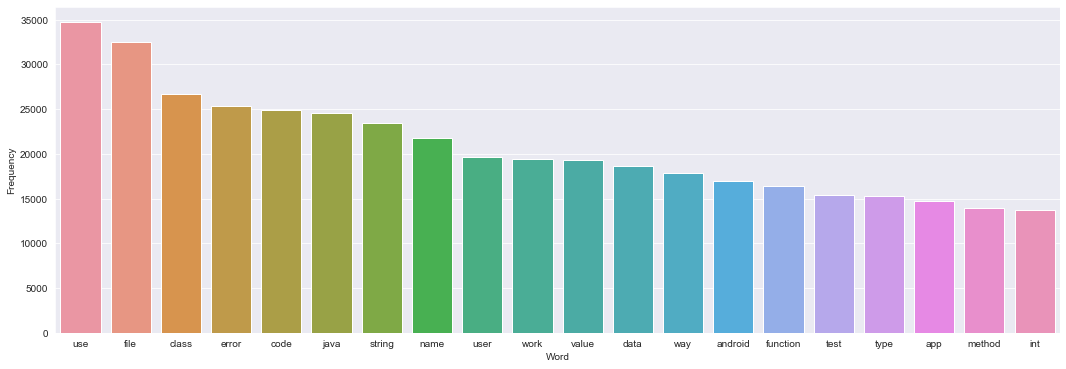

In [1154]:
fdist = nltk.FreqDist(corpus_copy)
words_corpus_df = pd.DataFrame({'Word':list(fdist.keys()), 'Frequency':list(fdist.values())})
    
# selecting top 20 most frequent words
df1 = words_corpus_df.nlargest(columns="Frequency", n=20) 
  
# visualize words and frequencies

plt.figure(figsize=(18,6))
sns.set_style("darkgrid")
sns.barplot(x=df1['Word'], y=df1['Frequency'])

**Tracé des mots les plus fréquents dans les Tags**

Nombre de mots de total notre corpus tag : 218910
Nombre de mots unique de notre corpus tag : 14080


<AxesSubplot:xlabel='Word', ylabel='Frequency'>

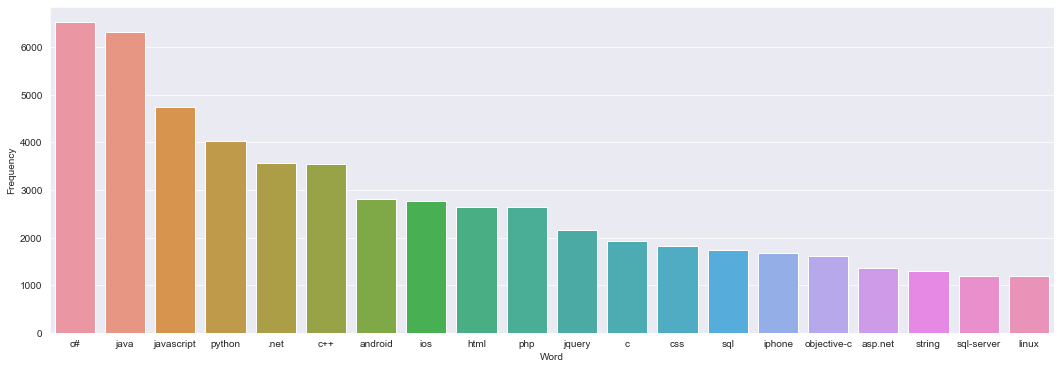

In [1155]:
#On contruit le corpus à partir de document_cleaned
corpus_tag =' '.join([text for text in data['Tags']])
corpus_tag_copy = corpus_tag.split()

print("Nombre de mots de total notre corpus tag :", len(corpus_tag_copy))
print("Nombre de mots unique de notre corpus tag :", len(set(corpus_tag_copy)))

fdist = nltk.FreqDist(corpus_tag_copy)
words_tags_df = pd.DataFrame({'Word':list(fdist.keys()), 'Frequency':list(fdist.values())})
    
# selecting top 20 most frequent words
df2 = words_tags_df.nlargest(columns="Frequency", n=20) 
  
# visualize words and frequencies

plt.figure(figsize=(18,6))
sns.set_style("darkgrid")
sns.barplot(x=df2['Word'], y=df2['Frequency'])

In [1156]:
from wordcloud import WordCloud
def visualize_most_word(distribution, place):
    """
    It plots most popular word uses in corpus (title or body or corp) feature
    place = title or body or corp
    """
    fig = plt.figure(1, figsize=(16, 12))
    ax = fig.add_subplot(1, 1, 1)
    wordcloud = WordCloud(width=900, height=500,
                           max_words=100, relative_scaling=1,
                          normalize_plurals=False)\
    .generate_from_frequencies(distribution.set_index('Word').to_dict()['Frequency'])
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off") 
    plt.title("Word Cloud of 100 most popular words on {} feature\n".format(str(place)),
              fontsize=24)
    plt.show()

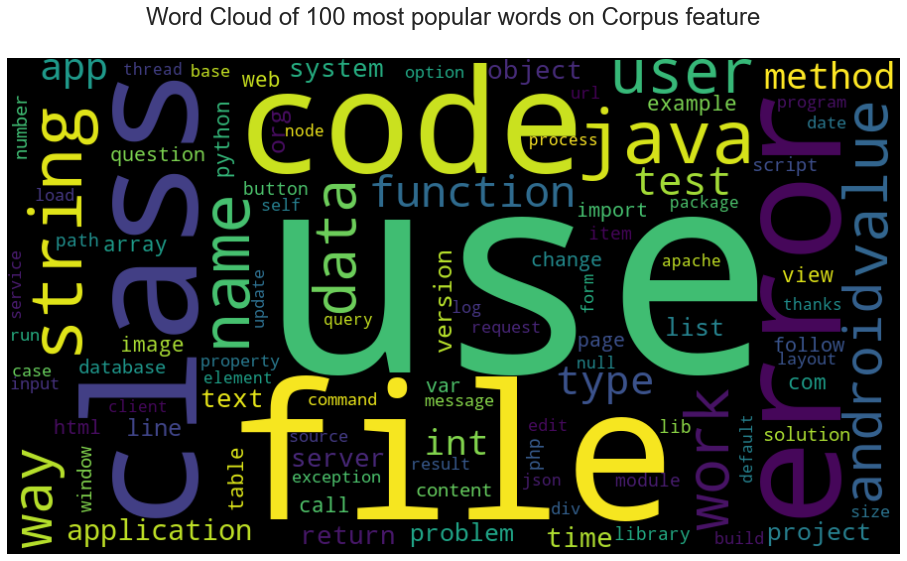

In [1157]:
visualize_most_word(words_corpus_df, 'Corpus')

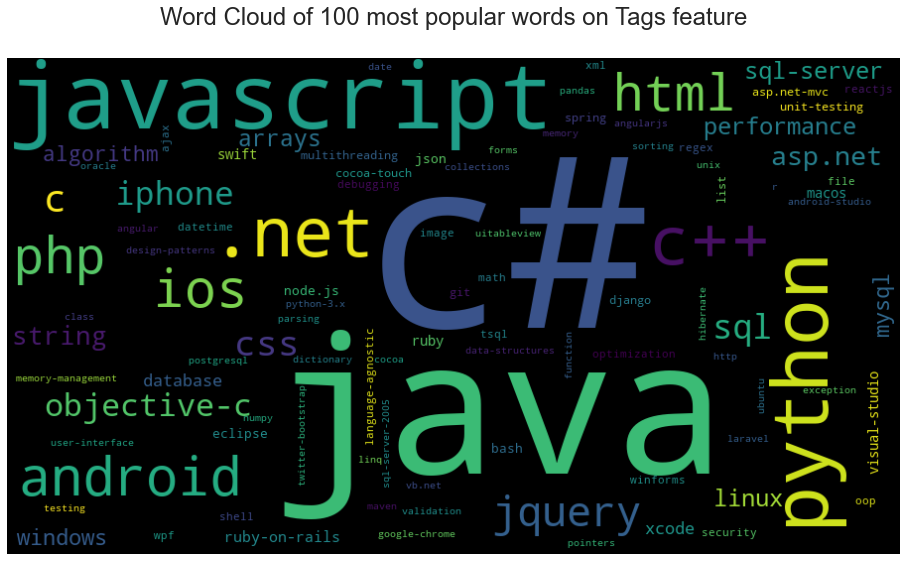

In [1158]:
visualize_most_word(words_tags_df , 'Tags')

Nous allons nous occuper des tokens rares dans notre corpus.

**List of rare tokens** (les tokens présents moins de 5 fois dans le corpus ne sont probablement pas utiles, un tokens rare sera sûrement exclus lors de la réduction de dimension)

In [1159]:
words_corpus_df.head()

,Word,Frequency
0,java,24566
1,arraylist,851
2,string,23434
3,reading,171
4,thread,5679


Distribution de la fréquence des tokens

In [1160]:
words_corpus_df.describe()

,Frequency
count,105015.000000
mean,29.465629
std,406.527766
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,34705.000000


In [1161]:
rare_tokens=words_corpus_df[words_corpus_df['Frequency']<5]
rare_tokens

,Word,Frequency
5,mull,4
49,callerfun,1
57,uikeyboardtaskqueue,2
104,rival,2
105,slickness,1
...,...,...
105010,getgoogleauth,1
105011,notreal,1
105012,flickrphotosearch,2
105013,flickrcontroller,1


In [1162]:
list_of_rare_tokens = list (rare_tokens['Word'])  # Transformer cette liste en dataframe (à voir)
print( len(rare_tokens), 'tokens', 'présents moins de 5 fois dans le corpus ')

80529 tokens présents moins de 5 fois dans le corpus 


Nous allons de ce qui suit conserver que les mots et les tags qui sont apparus plus de 100 fois.

In [1163]:
def frequent_words(corpus, min_count=100):
    """
    This function removes rare tokens from a corpus.

    Args:
    - corpus (list): a list of strings, each representing a document or sentence
    - min_count (int): the minimum number of times a token must appear in the corpus to be kept

    Returns:
    - list: a list of tokens that appear at least min_count times in the corpus
    """
    all_words = [word for doc in corpus for word in doc.split()]
    fdist = nltk.FreqDist(all_words)
    freq_words = [word for word, count in fdist.items() if count >= min_count]
    return freq_words


In [1164]:
Tags = [token.split(" ") for token in data['Tags']]
tags_more_frequent = frequent_words(data['Tags'])

1. <ins>  conservation des tags qui sont apparus plus de 100 fois et stockage dans la colonne **frequent_tags** </ins>

In [1165]:
data['temp'] = Tags
data['frequent_tags'] = data['temp'].apply(lambda x: ' '.join([tag for tag in x if tag in tags_more_frequent]))
del data['temp']

In [1166]:
X=data[['Tags', 'frequent_tags']]
X[['Tags', 'frequent_tags']].sample(10)

,Tags,frequent_tags
13255,jquery asp.net-mvc asp.net-mvc-3 jquery-va...,jquery asp.net-mvc asp.net-mvc-3
24461,linux email shell sendmail,linux email shell
11025,c++ c performance optimization cpu,c++ c performance optimization
14950,java maven tomcat noclassdeffounderror,java maven tomcat
11103,c# wpf binding checkbox,c# wpf
11440,java collections equals comparable compar...,java collections
35312,php http-headers content-type head respon...,php
21856,flutter dart snackbar scaffold,flutter dart
6534,python pandas scikit-learn feature-extract...,python pandas
12550,reactjs layout react-native background-image,reactjs layout react-native


In [1167]:
document_cleaned = [token.split(" ") for token in data['document_cleaned']]

In [1168]:
word_in_document_more_frequent = frequent_words(data['document_cleaned'])
len(set(word_in_document_more_frequent))

2608

2. <ins>conservation des mots qui sont apparus plus de 100 fois dans le corpus et stockage dans la colonne 'frequent_word' </ins>

In [1169]:
data['temp'] = document_cleaned 
data['frequent_word'] = data['temp'].apply(lambda x: ' '.join([word for word in x if word in word_in_document_more_frequent]))
del data['temp']

In [1170]:
#selection aléatoire que quelques lignes pour vérifier les effets de la selection effectuée.
data[['document_cleaned','frequent_word']].sample(10)

,document_cleaned,frequent_word
49954,spring data type class java lang object use sp...,spring data type class java lang object use sp...
11665,java memory bytearrayoutputstream file disk ne...,java memory file disk need map memory use byte...
42816,server return error proxy authentication error...,server return error proxy authentication error...
27745,comparison javascript way object javascript ex...,comparison javascript way object javascript ex...
10875,need microsoft access database python access m...,need microsoft access database python access m...
1269,redraw issue vista bit winforms compile cpu we...,issue vista bit winforms compile cpu well comp...
609,difference spin lock spin lock,difference spin lock spin lock
19173,run database operation oracle solution sql gui...,run database operation oracle solution sql gui...
34390,page use javascript page use javascript,page use javascript page use javascript
46001,bug track ticket redmine trac jira redmine tra...,bug track ticket track issue development team ...


In [1171]:
corpus =' '.join([text for text in data['document_cleaned']])
corpus_copy = corpus.split()



print("Nombre de mots de total notre corpus :", len(corpus_copy))
print("Nombre de mots unique de notre corpus :", len(set(corpus_copy)))

Nombre de mots de total notre corpus : 3094333
Nombre de mots unique de notre corpus : 105015


In [1172]:
corpus_filtered =' '.join([text for text in data['frequent_word']])
corpus_filtered_copy = corpus_filtered.split()


print("Nombre de mots de total notre corpus après conservation des mots les plus fréquents:", len(corpus_filtered_copy))
print("Nombre de mots unique de notre corpus après conservation des mots les plus fréquents:", len(set(corpus_filtered_copy)))

Nombre de mots de total notre corpus après conservation des mots les plus fréquents: 2600779
Nombre de mots unique de notre corpus après conservation des mots les plus fréquents: 2608


In [1173]:
data.head()

,Title,Body,Tags,Id,document,document_cleaned,frequent_tags,frequent_word
0,Is Java ArrayList / String / atomic variable r...,<p>I've been mulling this over &amp; reading b...,java synchronization multithreading arrayl...,2388808,Is Java ArrayList / String / atomic variable r...,java arraylist string reading thread mull read...,java multithreading arraylist,java arraylist string reading thread reading a...
1,GET vs. POST Best Practices,"<p>For my web application (PHP/MYSQL), I show ...",php html http forms rest,679013,GET vs. POST Best Practices <p>For my web appl...,post practice web application php mysql show l...,php html http forms rest,post practice web application php mysql show l...
2,How to mock a Kotlin singleton object?,<p>Given a Kotlin singleton object and a fun t...,mocking mockito kotlin powermock powermoc...,37977320,How to mock a Kotlin singleton object? <p>Give...,kotlin singleton object kotlin singleton objec...,mocking kotlin,kotlin singleton object kotlin singleton objec...
3,Error when dismissing view controller,<p>Getting an error when dismissing a view con...,ios objective-c xcode uiviewcontroller,20021107,Error when dismissing view controller <p>Getti...,error view controller error view controller in...,ios objective-c xcode,error view controller error view controller in...
4,Google Maps: How to create a custom InfoWindow?,<p>The default Google Maps InfoWindow for a ma...,javascript html css google-maps,3860277,Google Maps: How to create a custom InfoWindow...,google map custom infowindow default google ma...,javascript html css google-maps,google map custom default google map map marke...


Notre modélisation va se baser sur les colonnes frequent_word et frequent_tags

In [1174]:
# export the DataFrame to a CSV file
data.to_csv('data_cleaned.csv', index=False)

 <center> ------------------------------------------------------------------------------------------------------------------------------------ FIN DU NOTEBOOK ------------------------------------------------------------------------------------------------------- </center> 

## <center> ANNEXE :   (/!\LECTURE NON NECESSAIRE)</center>

In [1175]:
import spacy

txt = "Making make user dad is used and try"
# Create the Language object
nlp1 = spacy.load("en_core_web_sm")
doc = nlp1(txt)
doc

Making make user dad is used and try

In [1176]:
print("Base word:", [token.lemma_ for token in doc[1:10]])

Base word: ['make', 'user', 'dad', 'be', 'use', 'and', 'try']


In [1177]:
doc = nlp1(data.loc[1, 'document_cleaned'])
type(doc)
type(data.loc[1, 'document_cleaned'])
doc

post practice web application php mysql show list item link row item link href item php action item use post list post data use form item action item php item method post input type name action value input type submit value item form style button look link php curl rest issue

In [1178]:
pos_list = ["NOUN","PROPN"]
text_list = []
for token in doc:
        if(token.pos_ in pos_list):
            text_list.append(token.text)
join_text = " ".join(text_list)

join_text

'post practice web application php mysql show list item link row item link href item php action item post list post data form item action item php item method post input type name action value input type submit value item form style button look link php curl rest issue'

In [1179]:
data[data['document_cleaned'].str.startswith( 'html input line struggle html input name line side side use float rest input advise code html action contact php method post label name name label input name name name type text label name')]

,Title,Body,Tags,Id,document,document_cleaned,frequent_tags,frequent_word
21297,html form - make inputs appear on the same line,<p>I am struggling to make two html form input...,html forms css input,18470682,html form - make inputs appear on the same lin...,html input line struggle html input name line ...,html forms css input,html input line struggle html input name line ...


In [1180]:
# Dans le countvectoriser gérer les mots selon leur fréquence  (max df et min df )

#prochaine étape 
    #méthode d'extraction de features
        # 1.bag of words (tf et count)
        # 2.word/setence embedding (word2vec, bert and use) 



# Approche non supervisée : --> LDA + tfidf 
# Approche supervisée : --> [Regression log, Random forest , sgdclassifier ] x [ word2vec, USE, tfidf, Bert, Countvectorizer ]

In [1181]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document. the',
    'This document is the second document.',
    'And this is the third one. one and this one',
    'Is this the first document?',
    ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()




['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

test tfidf

In [1182]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the <> first document. ',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
    'html input line struggle html input name line side side use float rest input advise code html action contact php method post label name name label input name name name type text label name name label input name name name type text label email email label input name email email type email label telephone telephone label input name telephone telephone type tel label we wedding date label input name d d type date label requirement requirement label textarea name requirement requirement maxlength col row textarea input type submit value submit form contactpage form display block contactpage form label margin font size color font family roboto condense helvetica arial sans font weight line height contactpage form input border dddddd box shadow none webkit box shadow none moz box shadow none border radius moz border radius khtml border radius webkit border radius contactpage form input type text width display background font family helvetica neue arial helvetica sans font size line height pad contactpage form input type email contactpage form input type tel contactpage form input type date contactpage form textarea display block background font family helvetica neue arial helvetica sans font size line height pad contactpage form input type submit float display block background color font size font family roboto condense helvetica arial sans weight font style text transform uppercase text decoration none line height pad contactpage form input type submit color ffffff background bdb jsbin demo'
    ,'app heroku install gem bundler source gem rail gem gem mysql gem gem  gem tap gem  gem aws gem  gem  group asset gem sas rail gem coffee rail gem end group production gem  heroku gem end gem jquery rail output app heroku count object delta compression use thread object object   total delta delta heroku push ruby rail app dependency use bundler version run bundle opment test path vendor bundle  bin deployment fetch gem metadata instal rake multi json activesupport builder  instal rack cache rack mount rack test   sprocket  mime   mail    activerecord instal   aws  coffee script source coffee script rack instal json extension  coffee rail jquery rail mysql extension extension use bundler rail rest client instal instal sas instal sas rail   extension error error bundler issue  fix thanks usr local lib ruby installer  block extension error build gem extension gem installer  usr local bin ruby extconf miss port    check share library search path location share library locate extconf fail reason library header mkmf log file detail configuration option configuration option opt dir opt dir opt opt opt dir opt lib opt lib opt dir lib   ruby usr local bin ruby dir dir dir lib sqlite lib sqlite dir lib gem file tmp build vendor bundle ruby gems  result log tmp vendor bundle ruby gems ext gem usr local lib ruby installer block build extension usr local lib ruby installer usr local lib ruby installer build extension usr local lib ruby installer install tmp vendor bundle ruby gems bundler lib bundler source block install tmp vendor bundle ruby gems bundler lib bundler rubygems integration path tmp vendor bundle ruby gems bundler lib bundler source tmp vendor bundle ruby gems bundler lib bundler installer block install gem spec tmp vendor bundle ruby gems bundler lib bundler rubygems integration build args tmp vendor bundle ruby gems bundler lib bundler installer install gem spec tmp vendor bundle ruby gems bundler lib bundler installer block run tmp vendor bundle ruby gems bundler lib bundler installer run tmp vendor bundle ruby gems bundler lib bundler installer install tmp vendor bundle ruby gems bundler lib bundler cli tmp vendor bundle ruby gems bundler lib bundler vendor  task tmp vendor bundle ruby gems bundler lib bundler vendor  invocation invoke task tmp vendor bundle ruby gems bundler lib bundler vendor  dispatch tmp build vendor bundle ruby gems bundler lib bundler vendor  base tmp vendor bundle ruby gems bundler bin bundle top vendor bundle ruby bin bundle load vendor bundle ruby bin bundle fail install gem bundler gem support heroku heroku push compile ruby rail app git heroku com repo git remote  master master pre hook  error fail push ref git heroku com repo git wrong app work help problem  edit repository one'
    ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()


['action',
 'activerecord',
 'activesupport',
 'advise',
 'and',
 'app',
 'args',
 'arial',
 'asset',
 'aws',
 'background',
 'base',
 'bdb',
 'bin',
 'block',
 'border',
 'box',
 'build',
 'builder',
 'bundle',
 'bundler',
 'cache',
 'check',
 'cli',
 'client',
 'code',
 'coffee',
 'col',
 'color',
 'com',
 'compile',
 'compression',
 'condense',
 'configuration',
 'contact',
 'contactpage',
 'count',
 'date',
 'dddddd',
 'decoration',
 'delta',
 'demo',
 'dependency',
 'deployment',
 'detail',
 'dir',
 'dispatch',
 'display',
 'document',
 'edit',
 'email',
 'end',
 'error',
 'ext',
 'extconf',
 'extension',
 'fail',
 'family',
 'fetch',
 'ffffff',
 'file',
 'first',
 'fix',
 'float',
 'font',
 'form',
 'gem',
 'gems',
 'git',
 'group',
 'header',
 'height',
 'help',
 'helvetica',
 'heroku',
 'hook',
 'html',
 'input',
 'instal',
 'install',
 'installer',
 'integration',
 'invocation',
 'invoke',
 'is',
 'issue',
 'jquery',
 'jsbin',
 'json',
 'khtml',
 'label',
 'lib',
 'library',
 

'html input line struggle html input name line side side use float rest input advise code html action contact php method post label name name label input name name name type text label name name label input name name name type text label email email label input name email email type email label telephone telephone label input name telephone telephone type tel label we wedding date label input name d d type date label requirement requirement label textarea name requirement requirement maxlength col row textarea input type submit value submit form contactpage form display block contactpage form label margin font size color font family roboto condense helvetica arial sans font weight line height contactpage form input border dddddd box shadow none webkit box shadow none moz box shadow none border radius moz border radius khtml border radius webkit border radius contactpage form input type text width display background font family helvetica neue arial helvetica sans font size line height pad contactpage form input type email contactpage form input type tel contactpage form input type date contactpage form textarea display block background font family helvetica neue arial helvetica sans font size line height pad contactpage form input type submit float display block background color font size font family roboto condense helvetica arial sans weight font style text transform uppercase text decoration none line height pad contactpage form input type submit color ffffff background bdb jsbin demo'


In [1183]:
ind=random.randint(0, 30000)
texte = data.loc[ind,'document_cleaned']
texte= "window window msbuild framework form radio button window field database describe use xxxx type checkbox pair radio button foo way bar way field form data business object data bind pair radio button business object way button field field button button radio button pair value field update reflect button databindings check source usefoo button databindings check source usefoo way word checkbox want function commenter combobox thought field database property business object bind selecteditem property collection value pair object tie display item use foo use foo value trouble docs answer solution wound use business object idea post gurge response property radio button source usefoo source name property property getters wind behavior"
texte = data.loc[ind,'document_cleaned']
print('***'*25, 'Vraie phrase','***'*25, '\n')
print(texte)

*************************************************************************** Vraie phrase *************************************************************************** 

practice deal password git repository bash script use access twitter pop growl notification situation way store password script script git repo github wonder way login password password store script push commits password password option imagine store password config file check way handle
